In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import json

In [3]:
base_path = '/content/drive/MyDrive/research/valueclassifier/'

In [4]:
def preprocessEach(folder_name):
   # set file path
    folder_path = '/content/drive/MyDrive/research/valueclassifier/' + f'data/{folder_name}_clean'

    # load file name in folder
    file_names = os.listdir(folder_path)
    data_array = []

    for file in file_names:
        # set file path
        file_path = os.path.join(folder_path, file)
        
        # load csv file as dataframe
        df = pd.read_csv(file_path)

        #preprocessing column
        df['open-close'] = df['Open'] - df['Close'] #추가
        df['open-close'] = df['open-close'] + abs(min(df['open-close'])) #추가
        df['MA5'] = df['Close'].rolling(5).mean() #추가
        df['Diff'] = df['High'] - df['Low']
        df = df[['Close','Volume','Diff','open-close','MA5', 'Search']]
        df.fillna(0, inplace=True)

        #log transform
        df = np.log1p(df)

        #insert list to array
        data_array.append(df)

    return np.array(data_array)

In [5]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

<ipython-input-4-df52b63040ac>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
<ipython-input-4-df52b63040ac>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


In [6]:
def bootstrap(large, small):
    diff = len(large) - len(small)
    bootstrapped = small[np.random.choice(len(small), size=diff, replace=True)]
    return np.concatenate((small, bootstrapped), axis=0)

In [7]:
xValues = np.concatenate((xValues, xOverlaps), axis=0)

In [8]:
xGrowths = bootstrap(xValues, xGrowths)

In [9]:
def makeYValue(folder_name, filelength):

    if folder_name=='growth':
        yValues = np.zeros(filelength)
    elif folder_name=='value':
        yValues = np.ones(filelength)

    y = np.column_stack([yValues.T])
    return y

In [10]:
#make y values
yGrowths = makeYValue('growth', len(xGrowths))
yValues = makeYValue('value', len(xValues))

In [11]:
x = np.concatenate((xGrowths, xValues), axis=0)
y = np.concatenate((yGrowths, yValues), axis=0)

In [12]:
#minmax scaling by element
scaler = MinMaxScaler()
for i in range(6):
    x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [13]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [14]:
x_train, x_test, y_train, y_test = splitData(x, y)

In [15]:
#modify NaN to 0
x_train = np.nan_to_num(x_train, nan=0)
x_test = np.nan_to_num(x_test, nan=0)

In [16]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [17]:
x_train.shape #1713 data samples, 1248 days, 6 features

(2804, 1248, 6)

## Baseline model

In [18]:
model = Sequential()
model.add(GRU(64, input_shape=(1248,6), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(16))
model.add(Dense(2, activation='softmax'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
mc = ModelCheckpoint('best_model_value.h5', monitor='val_acc', mode='max', save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1248, 64)          13824     
                                                                 
 dropout (Dropout)           (None, 1248, 64)          0         
                                                                 
 gru_1 (GRU)                 (None, 16)                3936      
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
Total params: 17,794
Trainable params: 17,794
Non-trainable params: 0
_________________________________________________________________


In [20]:
#split data for cross validation
def splitDataCrossVal(x, y, fold=3):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    x_split = []
    y_split = []
    # split data
    n_samples = int(len(x)/fold)
    for i in range(fold-1):
      x_split.append(x[i*n_samples:(i+1)*n_samples])
      y_split.append(y[i*n_samples:(i+1)*n_samples])
    x_split.append(x[(fold-1)*n_samples:])
    y_split.append(y[(fold-1)*n_samples:])

    return x_split, y_split

In [21]:
def cvsplitData(x,y, ind):
  x_test = x[ind]
  y_test = y[ind]
  cnt = 0
  for i in range(len(x)):
    if i!=ind:
      if cnt == 0:
        x_train = x[i]
        y_train = y[i]
        cnt += 1
      else:
        x_train = np.concatenate((x_train, x[i]))
        y_train = np.concatenate((y_train, y[i]))
  return x_train, x_test, y_train, y_test

In [22]:
#cross validation
x_split, y_split = splitDataCrossVal(x_train,y_train)
print(len(x_split))
accuracy_cross_val = []
for i in range(len(x_split)):
  x_train_cv, x_val, y_train_cv, y_val = cvsplitData(x_split, y_split, i)
  x_train_cv = np.nan_to_num(x_train_cv, nan=0)
  x_val = np.nan_to_num(x_val, nan=0)

  history=model.fit(x_train_cv, y_train_cv, epochs=2000, validation_data=(x_val, y_val), callbacks=[es, mc])
  model=load_model('best_model_value.h5')
  loss, accuracy = model.evaluate(x_val, y_val)
  accuracy_cross_val.append(accuracy)
  with open(f'history_value{i}.json', 'w') as f:
      json.dump(history.history, f)
print("cross validation accuracy:{}".format(accuracy_cross_val))
print("average cross validation accuracy:{}".format(sum(accuracy_cross_val)/len(accuracy_cross_val)))

3
Epoch 1/2000
59/59 [==============================] - 15s 108ms/step - loss: 0.6827 - acc: 0.5706 - val_loss: 0.6733 - val_acc: 0.6028
Epoch 2/2000
59/59 [==============================] - 4s 69ms/step - loss: 0.6764 - acc: 0.5786 - val_loss: 0.6769 - val_acc: 0.5857
Epoch 3/2000
59/59 [==============================] - 5s 83ms/step - loss: 0.6739 - acc: 0.5797 - val_loss: 0.6753 - val_acc: 0.5525
Epoch 4/2000
59/59 [==============================] - 5s 83ms/step - loss: 0.6732 - acc: 0.5690 - val_loss: 0.6692 - val_acc: 0.5974
Epoch 5/2000
59/59 [==============================] - 4s 70ms/step - loss: 0.6698 - acc: 0.6005 - val_loss: 0.6679 - val_acc: 0.6113
Epoch 6/2000
59/59 [==============================] - 4s 74ms/step - loss: 0.6693 - acc: 0.5920 - val_loss: 0.6668 - val_acc: 0.6113
Epoch 7/2000
59/59 [==============================] - 6s 100ms/step - loss: 0.6662 - acc: 0.6043 - val_loss: 0.6705 - val_acc: 0.6028
Epoch 8/2000
59/59 [==============================] - 4s 70ms/st

In [23]:
hiostory_dict_list = []
for i in range(len(x_split)):
    with open(f'history_value{i}.json', 'r') as f:
        hiostory_dict_list.append(json.load(f))

In [24]:
count_01 = np.sum((y_test == [0,1]).all(axis=1))
count_10 = np.sum((y_test == [1,0]).all(axis=1))

print(f"[01]의 개수: {count_01}")
print(f"[10]의 개수: {count_10}")

[01]의 개수: 369
[10]의 개수: 333


In [25]:
best_model=load_model('best_model_value.h5')
loss, accuracy = best_model.evaluate(x_test, y_test)
y_pred_prob = best_model.predict(x_test)

22/22 [==============================] - 1s 25ms/step


In [30]:
y_pred_prob

array([[0.01423747, 0.9857625 ],
       [0.985187  , 0.01481302],
       [0.89594674, 0.10405322],
       ...,
       [0.00349542, 0.99650455],
       [0.9886225 , 0.01137755],
       [0.4183522 , 0.58164775]], dtype=float32)

In [26]:
def model_loss(history):
    epochs = range(1, len(history['val_acc']) + 1)
    plt.plot(epochs, history['loss'])
    plt.plot(epochs, history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [27]:
def model_acc(history):
    epochs = range(1, len(history['val_acc']) + 1)
    plt.plot(epochs, history['acc'])
    plt.plot(epochs, history['val_acc'])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

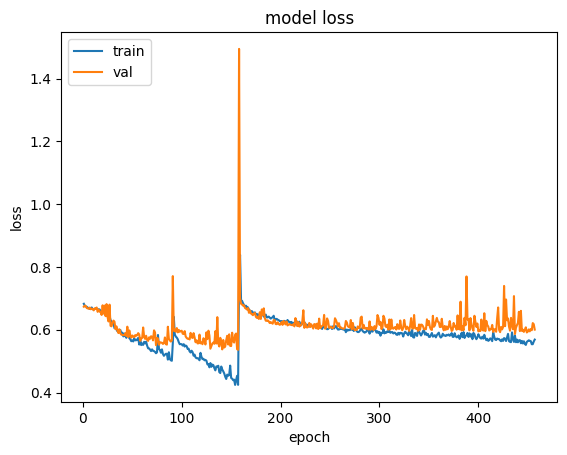

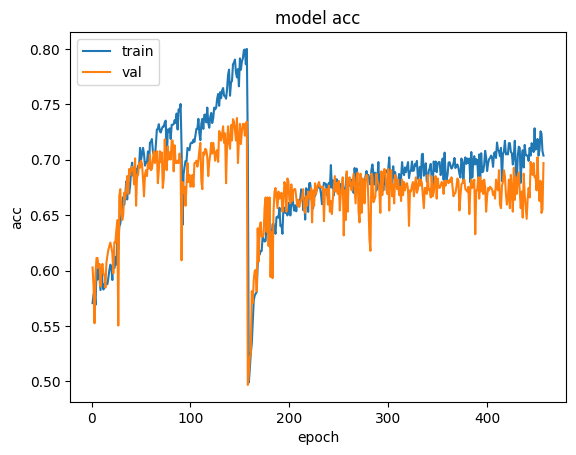

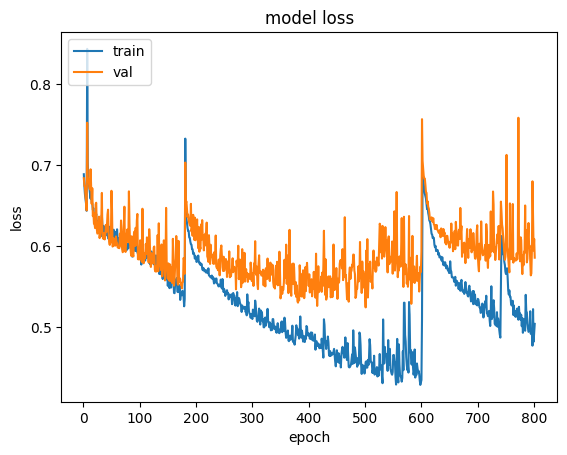

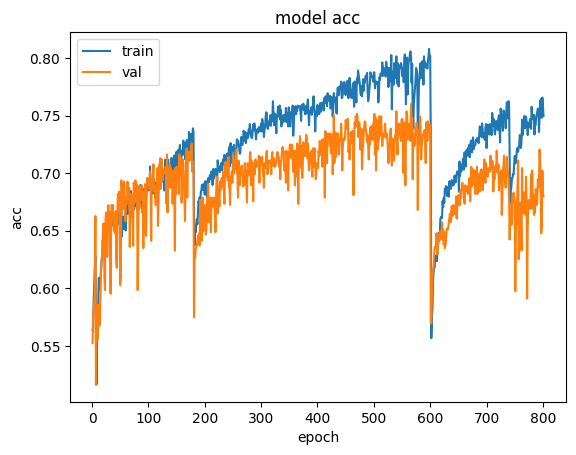

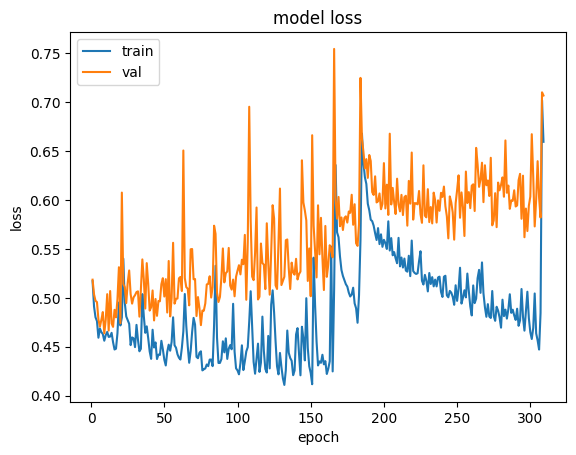

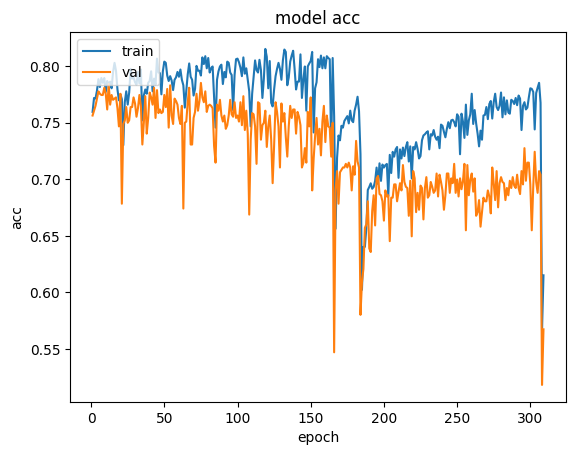

In [28]:
for i in hiostory_dict_list:
    model_loss(i)
    model_acc(i)

In [29]:
with open('history0.json', 'r') as f:
    history_dict0 = json.load(f)
with open('history1.json', 'r') as f:
    history_dict1 = json.load(f)
with open('history2.json', 'r') as f:
    history_dict2 = json.load(f)

FileNotFoundError: ignored

In [ ]:
epochs0 = range(1, len(history_dict0['acc']) + 1)
plt.plot(epochs0, history_dict0['loss'])
plt.plot(epochs0, history_dict0['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

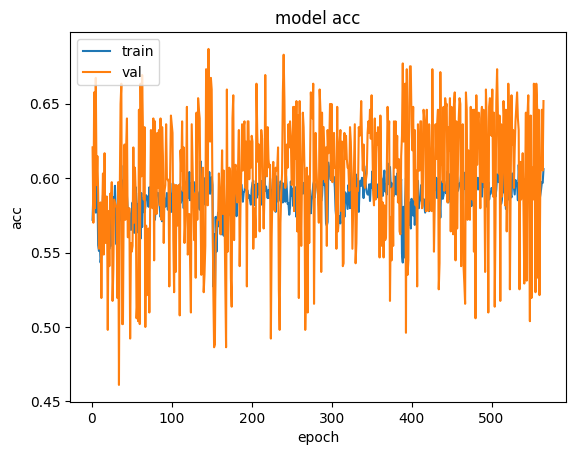

In [ ]:
epochs0 = range(1, len(history_dict0['acc']) + 1)
plt.plot(epochs0, history_dict0['acc'])
plt.plot(epochs0, history_dict0['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()